<a href="https://colab.research.google.com/github/Dragon4926/ocean-trash/blob/main/ocean-trash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation and Setup

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 57.2 MB/s eta 0:00:00


In [2]:
import requests
import zipfile
import os
import glob
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

## Download the Dataset


In [3]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [4]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

In [5]:
download_file(
    'https://www.dropbox.com/s/ievh0sesad015z0/trash_inst_material.zip?dl=1',
    'trash_inst_material.zip'
)

unzip(zip_file='trash_inst_material.zip')

Extracted all


## YOLO Dataset Label Format

All the labels are available in the corresponding text files inside the `labels` directories. Modern YOLO models use the following format in the text files.

`<class_number, x_center, y_center, normalized_width, normalized_height>`

The `class_number` ranges from `0` to the `num_classes-1`. So, if there are 16 classes in the dataset, the `class_number` will range from 0-15.

We will visit this again while preparing dataset YAML file.

## Model YAML File

In this section, we prepare the model YAML file. We have already covered the explanation of the YOLO YAML file in the YOLOv8 basic training notebook.

To reiterate, the YAML contains the paths to the different dataset splits and the class names.

In [6]:
cwd = os.getcwd()
print(cwd)

/content


In [7]:
import yaml

attr = {
    'path': cwd+'/trash_inst_material',
    'train': 'train/images',
    'val': 'val/images',

    'names': {
        0: 'rov',
        1: 'plant',
        2: 'animal_fish',
        3: 'animal_starfish',
        4: 'animal_shells',
        5: 'animal_crab',
        6: 'animal_eel',
        7: 'animal_etc',
        8: 'trash_etc',
        9: 'trash_fabric',
        10: 'trash_fishing_gear',
        11: 'trash_metal',
        12: 'trash_paper',
        13: 'trash_plastic',
        14: 'trash_rubber',
        15: 'trash_wood',
    }
}

In [8]:
with open('trashcan_inst_material.yaml', 'w') as f:
    yaml.dump(attr, f)

### **YOLOv8 Training**

In [9]:
EPOCHS = 5
!yolo \
task=detect \
mode=train \
model=yolov8m-seg.pt \
imgsz=640 \
data=trashcan_inst_material.yaml \
epochs={EPOCHS} \
batch=16 \
name=yolov8m-seg \
exist_ok=True \
amp=False

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 52.4M/52.4M [00:00<00:00, 398MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=trashcan_inst_material.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m-seg, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, 

We get the best results using the YOLOv8m model. We have a box mAP of almost 50 and mask mAP of 37.8 which is pretty good.But gpu usage is considerabely HIGH.

## Image Inference

As we have the trained models now, let's use the best model for running inference on some images.

In [10]:
# Download the inference data.
download_file(
    'https://www.dropbox.com/s/smdsotzz5al3bi2/trash_segment_inference_data.zip?dl=1',
    'trash_segment_inference_data.zip'
)

unzip(zip_file='trash_segment_inference_data.zip')

Extracted all


Before that, following is a simple image visualization function.

In [11]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir):
    """
    Function accepts a list of images and plots
    them in either a 1x1 grid or 2x2 grid.
    """
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    if len(image_names) < 4:
        plt.figure(figsize=(10, 7))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(1, 1, i+1)
            plt.imshow(image)
            plt.axis('off')
            break
    if len(image_names) >= 4:
        plt.figure(figsize=(15, 12))
        for i, image_name in enumerate(image_names):
            image = plt.imread(image_name)
            plt.subplot(2, 2, i+1)
            plt.imshow(image)
            plt.axis('off')
            if i == 3:
                break
    plt.tight_layout()
    plt.show()

In [12]:
!yolo predict \
model='runs/segment/yolov8m-seg/weights/best.pt' \
source='trash_inst_material/val/images/' \
name='yolov8m_predict' \
exist_ok=True \
save=True

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,231,648 parameters, 0 gradients, 110.0 GFLOPs

image 1/1204 /content/trash_inst_material/val/images/vid_000002_frame0000013.jpg: 384x640 1 trash_plastic, 78.5ms
image 2/1204 /content/trash_inst_material/val/images/vid_000002_frame0000014.jpg: 384x640 1 trash_etc, 1 trash_plastic, 30.8ms
image 3/1204 /content/trash_inst_material/val/images/vid_000002_frame0000015.jpg: 384x640 1 trash_plastic, 30.8ms
image 4/1204 /content/trash_inst_material/val/images/vid_000002_frame0000016.jpg: 384x640 1 trash_etc, 30.8ms
image 5/1204 /content/trash_inst_material/val/images/vid_000002_frame0000017.jpg: 384x640 1 trash_plastic, 26.2ms
image 6/1204 /content/trash_inst_material/val/images/vid_000002_frame0000018.jpg: 384x640 1 trash_etc, 25.2ms
image 7/1204 /content/trash_inst_material/val/images/vid_000002_frame0000019.jpg: 384x640 1 trash_etc, 25.3ms
image 8/1204 /content/trash_

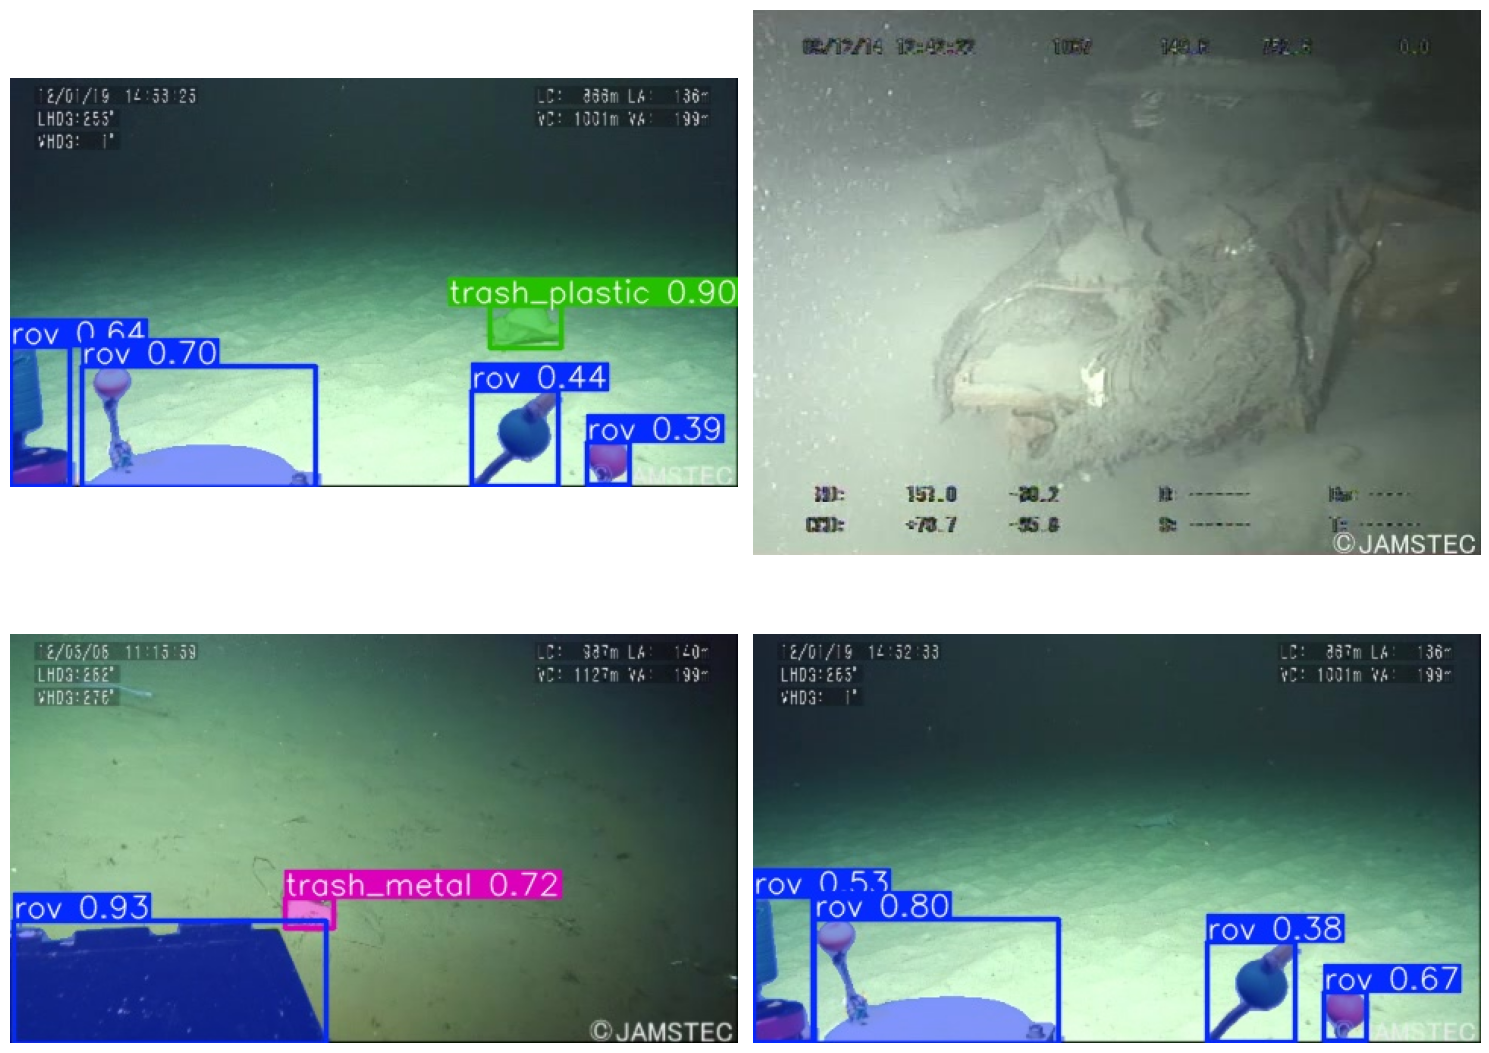

In [13]:
visualize('runs/segment/yolov8m_predict')

## Inference on Videos

For one final testing, let's run inference on videos.

In [14]:
!yolo predict \
model='runs/segment/yolov8m-seg/weights/best.pt' \
source='trash_segment_inference_data/manythings.mp4' \
name='yolov8m_predict_videos1' \
exist_ok=True \
save=True

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-seg summary (fused): 245 layers, 27,231,648 parameters, 0 gradients, 110.0 GFLOPs

video 1/1 (frame 1/1168) /content/trash_segment_inference_data/manythings.mp4: 480x640 (no detections), 76.0ms
video 1/1 (frame 2/1168) /content/trash_segment_inference_data/manythings.mp4: 480x640 1 rov, 34.0ms
video 1/1 (frame 3/1168) /content/trash_segment_inference_data/manythings.mp4: 480x640 (no detections), 34.0ms
video 1/1 (frame 4/1168) /content/trash_segment_inference_data/manythings.mp4: 480x640 (no detections), 33.9ms
video 1/1 (frame 5/1168) /content/trash_segment_inference_data/manythings.mp4: 480x640 1 rov, 34.0ms
video 1/1 (frame 6/1168) /content/trash_segment_inference_data/manythings.mp4: 480x640 1 rov, 33.9ms
video 1/1 (frame 7/1168) /content/trash_segment_inference_data/manythings.mp4: 480x640 (no detections), 34.0ms
video 1/1 (frame 8/1168) /content/trash_segment_inference_data/manythings.mp4: 4